# 🔍 Análisis Exploratorio de Datos - Monitor de Precios SIPC

**Proyecto:** Análisis de Precios al Consumidor en Uruguay  
**Fuente de Datos:** Sistema de Información de Precios al Consumidor (SIPC)  
**Institución:** Universidad Católica del Uruguay - Campus Salto  
**Curso:** Big Data

---

## Objetivo del Notebook

Realizar un **análisis exploratorio exhaustivo** de los datos raw (zona intermedia del Data Lake) para:

- 📊 Entender la estructura y volumen de datos
- 🔎 Identificar patrones y tendencias iniciales
- ✅ Validar calidad de datos (nulos, duplicados, outliers)
- 🗺️ Analizar distribuciones geográficas y temporales
- 🔗 Verificar relaciones entre tablas

## Datos Analizados

Este notebook trabaja con datos de la **zona RAW** del Data Lake:

- `raw/precios.parquet` - ~20M+ observaciones de precios
- `raw/productos.parquet` - ~379 productos del catálogo
- `raw/establecimientos.parquet` - ~852 puntos de venta

---

In [1]:
# Imports necesarios
import sys
from pathlib import Path

# Agregar el directorio src al path para imports
sys.path.insert(0, str(Path('..').absolute()))

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Librerías importadas correctamente")
print(f"📁 Path agregado: {Path('..').absolute()}")


✅ Librerías importadas correctamente
📁 Path agregado: /home/jovyan/work/..


In [2]:
# Inicializar Spark Session
spark = SparkSession.builder \
    .appName("SIPC - Exploracion de Datos") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"✅ Spark Session iniciada: {spark.version}")
print(f"📊 Configuración: {spark.sparkContext.getConf().getAll()}")

✅ Spark Session iniciada: 3.5.0
📊 Configuración: [('spark.driver.port', '41851'), ('spark.driver.memory', '4g'), ('spark.executor.id', 'driver'), ('spark.app.submitTime', '1764690449021'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect

## 1. Exploración de Datos RAW

### 1.1 Tabla de Precios

In [3]:
# Cargar datos de precios desde la zona RAW
df_precios = spark.read.parquet('data_sipc/raw/precios')

print("📊 INFORMACIÓN GENERAL - PRECIOS")
print("=" * 80)
print(f"Total de registros: {df_precios.count():,}")
print(f"Total de columnas: {len(df_precios.columns)}")
print(f"\nEsquema de datos:")
df_precios.printSchema()

📊 INFORMACIÓN GENERAL - PRECIOS
Total de registros: 20,516,701
Total de columnas: 5

Esquema de datos:
root
 |-- fecha: date (nullable = true)
 |-- producto_id: string (nullable = true)
 |-- establecimiento_id: string (nullable = true)
 |-- precio: double (nullable = true)
 |-- oferta: integer (nullable = true)



In [4]:
# Vista previa de los datos
print("\n🔍 PRIMERAS 20 FILAS:")
df_precios.show(20, truncate=False)


🔍 PRIMERAS 20 FILAS:
+----------+-----------+------------------+------+------+
|fecha     |producto_id|establecimiento_id|precio|oferta|
+----------+-----------+------------------+------+------+
|2025-08-21|358        |92                |63.0  |0     |
|2025-08-21|145        |180               |75.0  |0     |
|2025-08-21|145        |192               |75.0  |0     |
|2025-08-21|125        |83                |77.0  |0     |
|2025-08-21|125        |144               |65.0  |0     |
|2025-08-21|359        |101               |99.0  |0     |
|2025-08-21|15         |181               |75.0  |0     |
|2025-08-21|70         |97                |97.0  |0     |
|2025-08-21|203        |202               |149.0 |0     |
|2025-08-21|134        |205               |74.0  |0     |
|2025-08-21|3          |103               |89.0  |0     |
|2025-08-21|15         |199               |79.0  |0     |
|2025-08-21|43         |95                |252.0 |0     |
|2025-08-21|43         |83                |252.0 |

In [5]:
# Estadísticas descriptivas
print("\n📈 ESTADÍSTICAS DESCRIPTIVAS - PRECIO:")
df_precios.select('precio').describe().show()

print("\n📊 DISTRIBUCIÓN DE OFERTAS:")
df_precios.groupBy('oferta').count().orderBy('count', ascending=False).show()


📈 ESTADÍSTICAS DESCRIPTIVAS - PRECIO:
+-------+------------------+
|summary|            precio|
+-------+------------------+
|  count|          20516701|
|   mean|198.27835184021004|
| stddev|225.16612715358679|
|    min|              16.0|
|    max|            2580.0|
+-------+------------------+


📊 DISTRIBUCIÓN DE OFERTAS:
+------+--------+
|oferta|   count|
+------+--------+
|     0|18331449|
|     1| 2185252|
+------+--------+



In [6]:
# Análisis temporal
print("\n📅 DISTRIBUCIÓN TEMPORAL DE REGISTROS:")
temporal_stats = df_precios.groupBy('fecha') \
    .agg(
        F.count('*').alias('cantidad_registros'),
        F.avg('precio').alias('precio_promedio'),
        F.min('precio').alias('precio_minimo'),
        F.max('precio').alias('precio_maximo')
    ) \
    .orderBy('fecha')

temporal_stats.show(30)

# Convertir a Pandas para visualización
df_temporal_pd = temporal_stats.toPandas()
df_temporal_pd['fecha'] = pd.to_datetime(df_temporal_pd['fecha'])


📅 DISTRIBUCIÓN TEMPORAL DE REGISTROS:
+----------+------------------+------------------+-------------+-------------+
|     fecha|cantidad_registros|   precio_promedio|precio_minimo|precio_maximo|
+----------+------------------+------------------+-------------+-------------+
|2025-01-01|             66996|207.84213354529874|         19.9|       2580.0|
|2025-01-02|             68295| 207.2165913610213|         19.0|       2580.0|
|2025-01-03|             68479|206.86863400459916|         19.0|       2580.0|
|2025-01-04|             69008|207.07748885637838|         19.0|       2580.0|
|2025-01-05|             68117| 207.6504305533267|         19.0|       2580.0|
|2025-01-06|             68680|207.33894497671832|         19.0|       2580.0|
|2025-01-07|             68814|206.78055131224713|         19.0|       2580.0|
|2025-01-08|             68631| 207.4701303784151|         19.0|       2580.0|
|2025-01-09|             68955|206.86627870351714|         19.0|       2580.0|
|2025-01-10| 

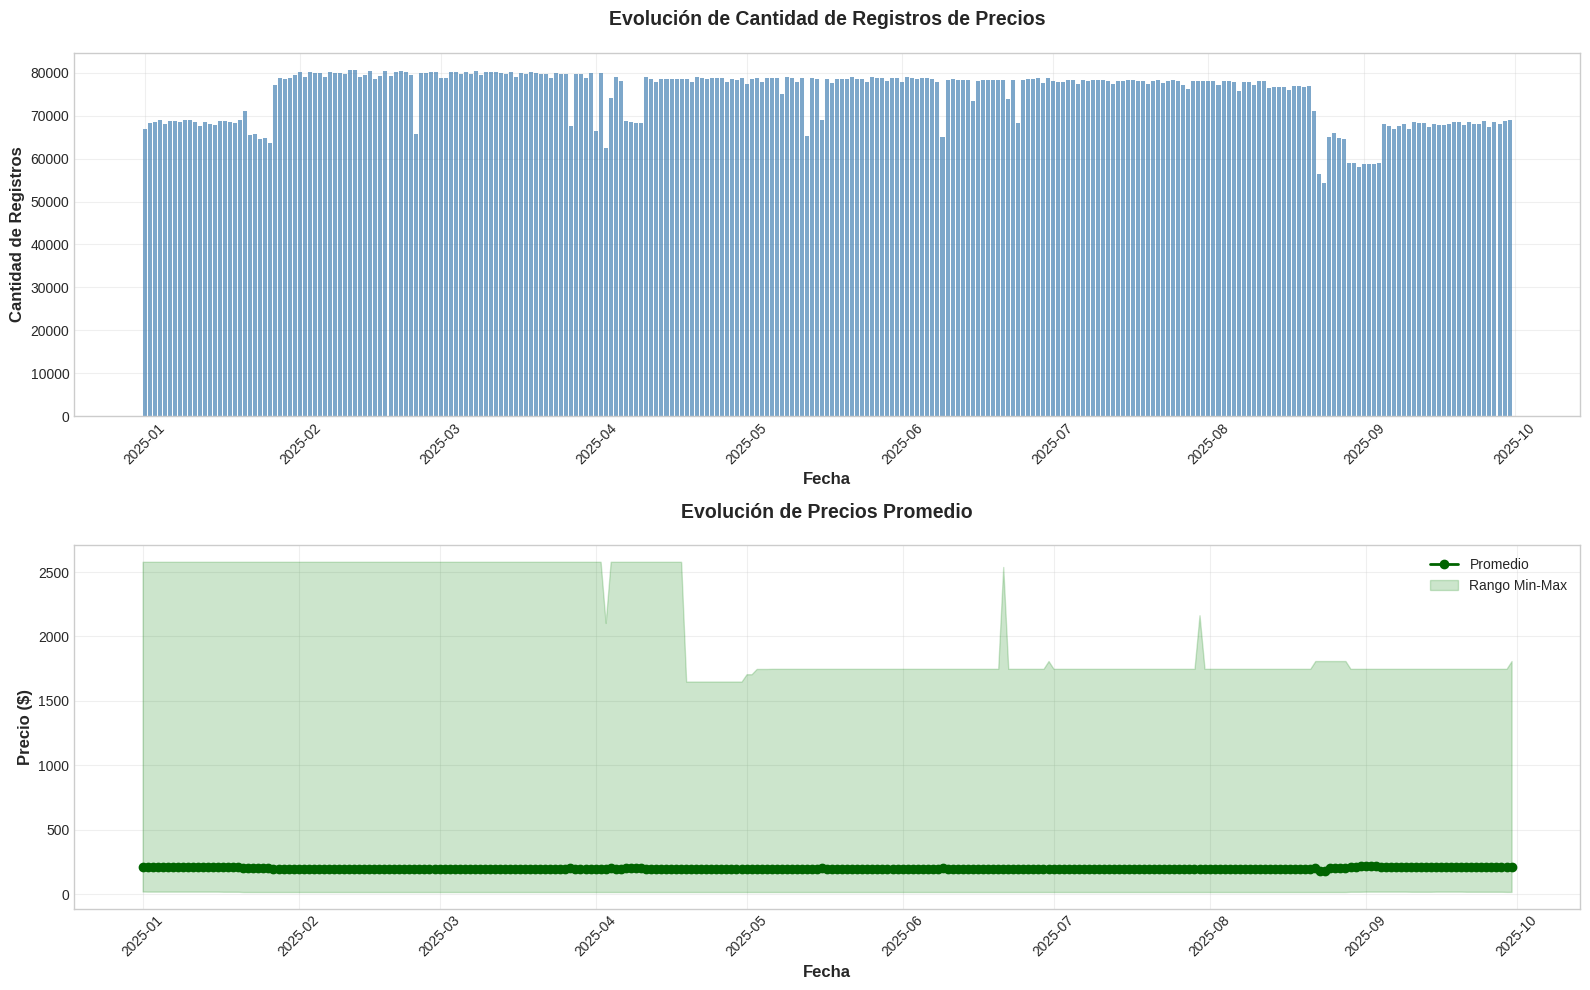

In [7]:
# Visualización de evolución temporal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Cantidad de registros por fecha
ax1.bar(df_temporal_pd['fecha'], df_temporal_pd['cantidad_registros'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cantidad de Registros', fontsize=12, fontweight='bold')
ax1.set_title('Evolución de Cantidad de Registros de Precios', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Precio promedio por fecha
ax2.plot(df_temporal_pd['fecha'], df_temporal_pd['precio_promedio'], marker='o', linewidth=2, color='darkgreen', label='Promedio')
ax2.fill_between(df_temporal_pd['fecha'], df_temporal_pd['precio_minimo'], df_temporal_pd['precio_maximo'], alpha=0.2, color='green', label='Rango Min-Max')
ax2.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precio ($)', fontsize=12, fontweight='bold')
ax2.set_title('Evolución de Precios Promedio', fontsize=14, fontweight='bold', pad=20)
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


💰 ANÁLISIS DE DISTRIBUCIÓN DE PRECIOS:


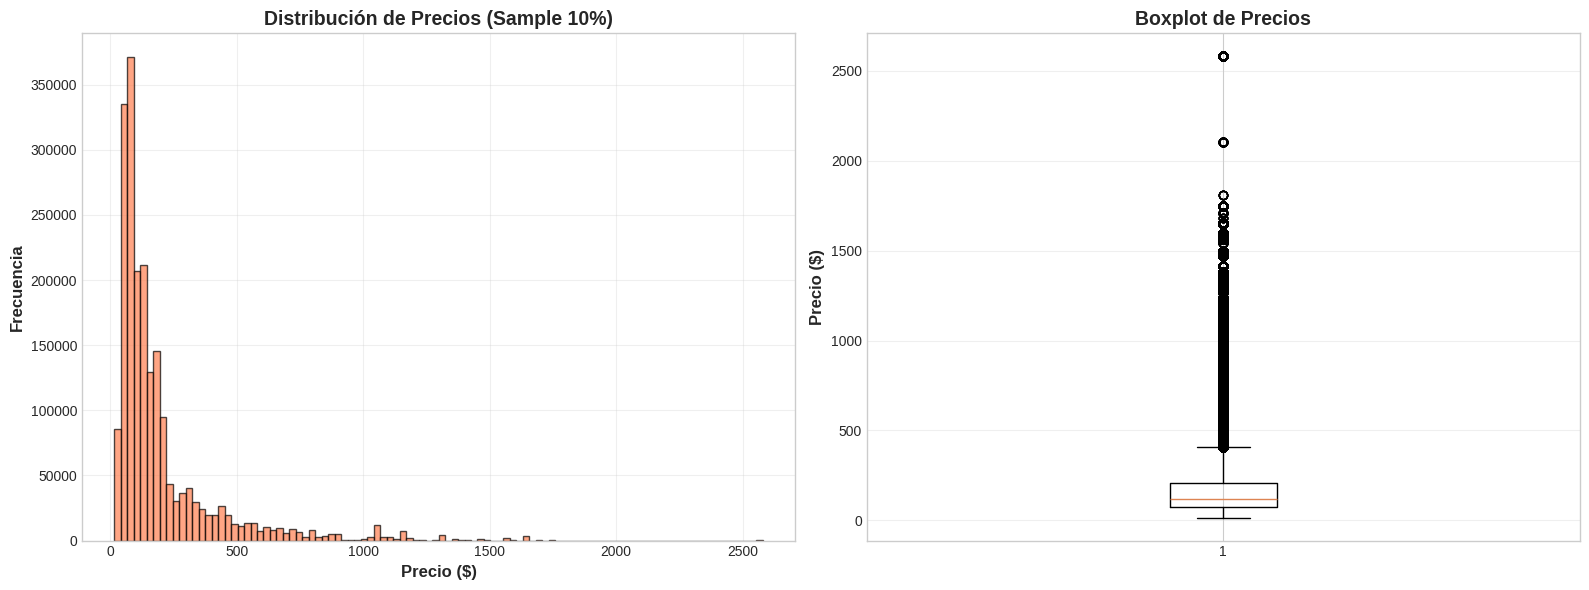

In [8]:
# Análisis de distribución de precios
print("\n💰 ANÁLISIS DE DISTRIBUCIÓN DE PRECIOS:")

# Obtener muestra de precios para visualización
precios_sample = df_precios.select('precio').sample(False, 0.1).toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histograma
ax1.hist(precios_sample['precio'], bins=100, color='coral', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Precio ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Precios (Sample 10%)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Boxplot
ax2.boxplot(precios_sample['precio'], vert=True)
ax2.set_ylabel('Precio ($)', fontsize=12, fontweight='bold')
ax2.set_title('Boxplot de Precios', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 1.2 Tabla de Productos

In [9]:
# Cargar datos de productos
df_productos = spark.read.parquet('data_sipc/raw/productos')

print("📊 INFORMACIÓN GENERAL - PRODUCTOS")
print("=" * 80)
print(f"Total de productos: {df_productos.count():,}")
print(f"Total de columnas: {len(df_productos.columns)}")
print(f"\nEsquema de datos:")
df_productos.printSchema()

📊 INFORMACIÓN GENERAL - PRODUCTOS
Total de productos: 379
Total de columnas: 7

Esquema de datos:
root
 |-- producto_id: string (nullable = true)
 |-- producto: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- especificacion: string (nullable = true)
 |-- nombre: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- subcategoria: string (nullable = true)



In [10]:
# Vista previa
print("\n🔍 PRIMERAS 20 FILAS:")
df_productos.show(20, truncate=False)


🔍 PRIMERAS 20 FILAS:
+-----------+--------------------+---------------------+---------------+-------------------------------------------------+--------------------+---------------+
|producto_id|producto            |marca                |especificacion |nombre                                           |categoria           |subcategoria   |
+-----------+--------------------+---------------------+---------------+-------------------------------------------------+--------------------+---------------+
|1          |Aceite de girasol   |Óptimo               |Envase 900 cc  |Aceite de girasol Óptimo Envase 900 cc           |Aceite de girasol   |Envase 900 cc  |
|10         |Agua de mesa con gas|Matutina             |Envase 2 lt.   |Agua de mesa con gas Matutina Envase 2 lt.       |Agua de mesa con gas|Envase 2 lt.   |
|100        |Leonesa             |Ottonello            |1 kg.          |Leonesa Ottonello 1 kg.                          |Leonesa             |1 kg.          |
|101        |Leone

In [11]:
# Análisis de categorías
print("\n📦 DISTRIBUCIÓN POR CATEGORÍA:")
df_productos.groupBy('categoria') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(50, truncate=False)

print("\n📦 DISTRIBUCIÓN POR SUBCATEGORÍA (Top 30):")
df_productos.groupBy('subcategoria') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(30, truncate=False)


📦 DISTRIBUCIÓN POR CATEGORÍA:
+--------------------------------+-----+
|categoria                       |count|
+--------------------------------+-----+
|Harina trigo común 0000         |8    |
|Lápiz Negro                     |8    |
|Marcadores delgados             |7    |
|Aceite de girasol               |6    |
|Arroz blanco                    |6    |
|Margarina                       |5    |
|Pasta dental                    |5    |
|Champú                          |5    |
|Cuadernola                      |5    |
|Bolígrafo                       |5    |
|Gaseosa tipo cola (env. no ret.)|5    |
|Lápices de colores              |5    |
|Jabón de tocador                |5    |
|Marcador flúor                  |4    |
|Repelente aerosol               |4    |
|Cuaderno Rayado                 |4    |
|Cuadernola                      |4    |
|Hojas de Garbanzo               |4    |
|Hipoclorito de sodio            |3    |
|Desodorante en aerosol          |3    |
|Leonesa                  

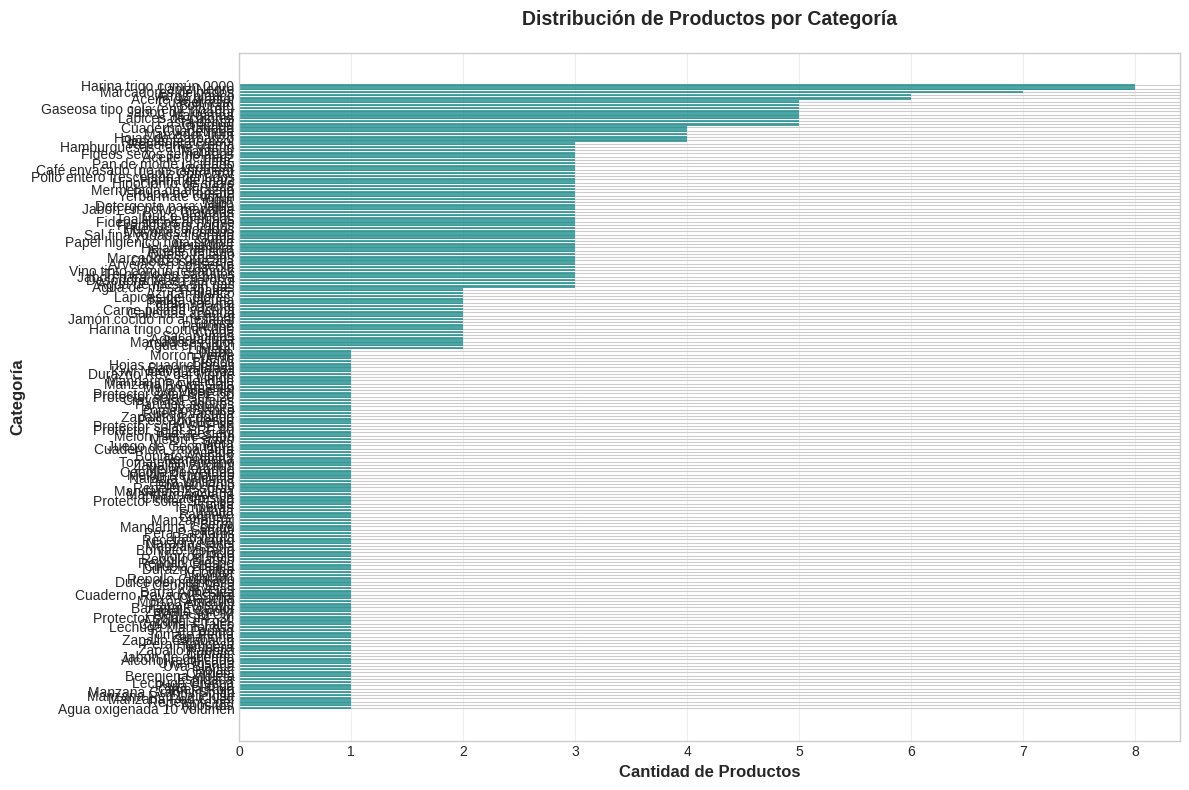

In [12]:
# Visualización de categorías
categorias_pd = df_productos.groupBy('categoria').count().toPandas().sort_values('count', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(categorias_pd['categoria'], categorias_pd['count'], color='teal', alpha=0.7)
ax.set_xlabel('Cantidad de Productos', fontsize=12, fontweight='bold')
ax.set_ylabel('Categoría', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Productos por Categoría', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [13]:
# Análisis de marcas
print("\n🏷️ TOP 20 MARCAS:")
df_productos.groupBy('marca') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(20, truncate=False)


🏷️ TOP 20 MARCAS:
+---------------------+-----+
|marca                |count|
+---------------------+-----+
|NULL                 |74   |
|Bic                  |13   |
|Papiros              |10   |
|Maped                |8    |
|Faber                |7    |
|Extreme              |5    |
|Off!                 |5    |
|Stabilo              |5    |
|School               |5    |
|Con Hueso - Sin Marca|4    |
|Sin Marca            |4    |
|Conaprole            |4    |
|Cololó               |4    |
|Ottonello            |3    |
|Los Nietitos         |3    |
|Acrilex              |3    |
|Tabaré               |3    |
|Schneck              |3    |
|Sin Hueso - Sin Marca|3    |
|Salus                |3    |
+---------------------+-----+
only showing top 20 rows



### 1.3 Tabla de Establecimientos

In [14]:
# Cargar datos de establecimientos
df_establecimientos = spark.read.parquet('data_sipc/raw/establecimientos')

print("📊 INFORMACIÓN GENERAL - ESTABLECIMIENTOS")
print("=" * 80)
print(f"Total de establecimientos: {df_establecimientos.count():,}")
print(f"Total de columnas: {len(df_establecimientos.columns)}")
print(f"\nEsquema de datos:")
df_establecimientos.printSchema()

📊 INFORMACIÓN GENERAL - ESTABLECIMIENTOS
Total de establecimientos: 852
Total de columnas: 15

Esquema de datos:
root
 |-- establecimiento_id: string (nullable = true)
 |-- razon_social: string (nullable = true)
 |-- nombre: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- ccz: string (nullable = true)
 |-- barrio: string (nullable = true)
 |-- cajas: string (nullable = true)
 |-- cadena: string (nullable = true)
 |-- long: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- depto: string (nullable = true)
 |-- id.depto: string (nullable = true)
 |-- localidad: string (nullable = true)
 |-- superficie (m2): string (nullable = true)



In [15]:
# Vista previa
print("\n🔍 PRIMERAS 20 FILAS:")
df_establecimientos.show(20, truncate=False)


🔍 PRIMERAS 20 FILAS:
+------------------+---------------------+-----------------------+---------------------------------+----+-------------+-----+----------+------------+------------+-----------------+-----------+--------+---------+---------------+
|establecimiento_id|razon_social         |nombre                 |direccion                        |ccz |barrio       |cajas|cadena    |long        |lat         |ciudad           |depto      |id.depto|localidad|superficie (m2)|
+------------------+---------------------+-----------------------+---------------------------------+----+-------------+-----+----------+------------+------------+-----------------+-----------+--------+---------+---------------+
|1                 |CAFITUR S.A.         |Expres 2               |AVDA. MILLAN 2683                |16  |Reducto      |2    |Sin Cadena|-34,8765665 |-56,1897221 |Montevideo       |Montevideo |1       |1020     |280            |
|10                |DALTIRO S.A.         |El Clon - Palacio      |

In [16]:
# Análisis geográfico
print("\n🗺️ DISTRIBUCIÓN POR DEPARTAMENTO:")
df_establecimientos.groupBy('depto') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(25, truncate=False)

print("\n🏙️ TOP 20 CIUDADES:")
df_establecimientos.groupBy('ciudad') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(20, truncate=False)



🗺️ DISTRIBUCIÓN POR DEPARTAMENTO:
+--------------+-----+
|depto         |count|
+--------------+-----+
|Montevideo    |473  |
|Canelones     |101  |
|Maldonado     |81   |
|San José      |23   |
|Colonia       |23   |
|Rocha         |19   |
|Salto         |19   |
|Soriano       |17   |
|Paysandú      |12   |
|Florida       |11   |
|Tacuarembó    |11   |
|Durazno       |11   |
|Río Negro     |9    |
|Cerro Largo   |9    |
|Rivera        |8    |
|Flores        |8    |
|Lavalleja     |8    |
|Treinta y Tres|5    |
|Artigas       |3    |
|Canelones     |1    |
+--------------+-----+


🏙️ TOP 20 CIUDADES:
+----------------------+-----+
|ciudad                |count|
+----------------------+-----+
|Montevideo            |473  |
|Maldonado             |29   |
|Ciudad de la Costa    |28   |
|Punta del Este        |21   |
|Salto                 |19   |
|Las Piedras           |17   |
|Mercedes              |14   |
|Colonia del Sacramento|12   |
|Paysandú              |12   |
|San José de Mayo  

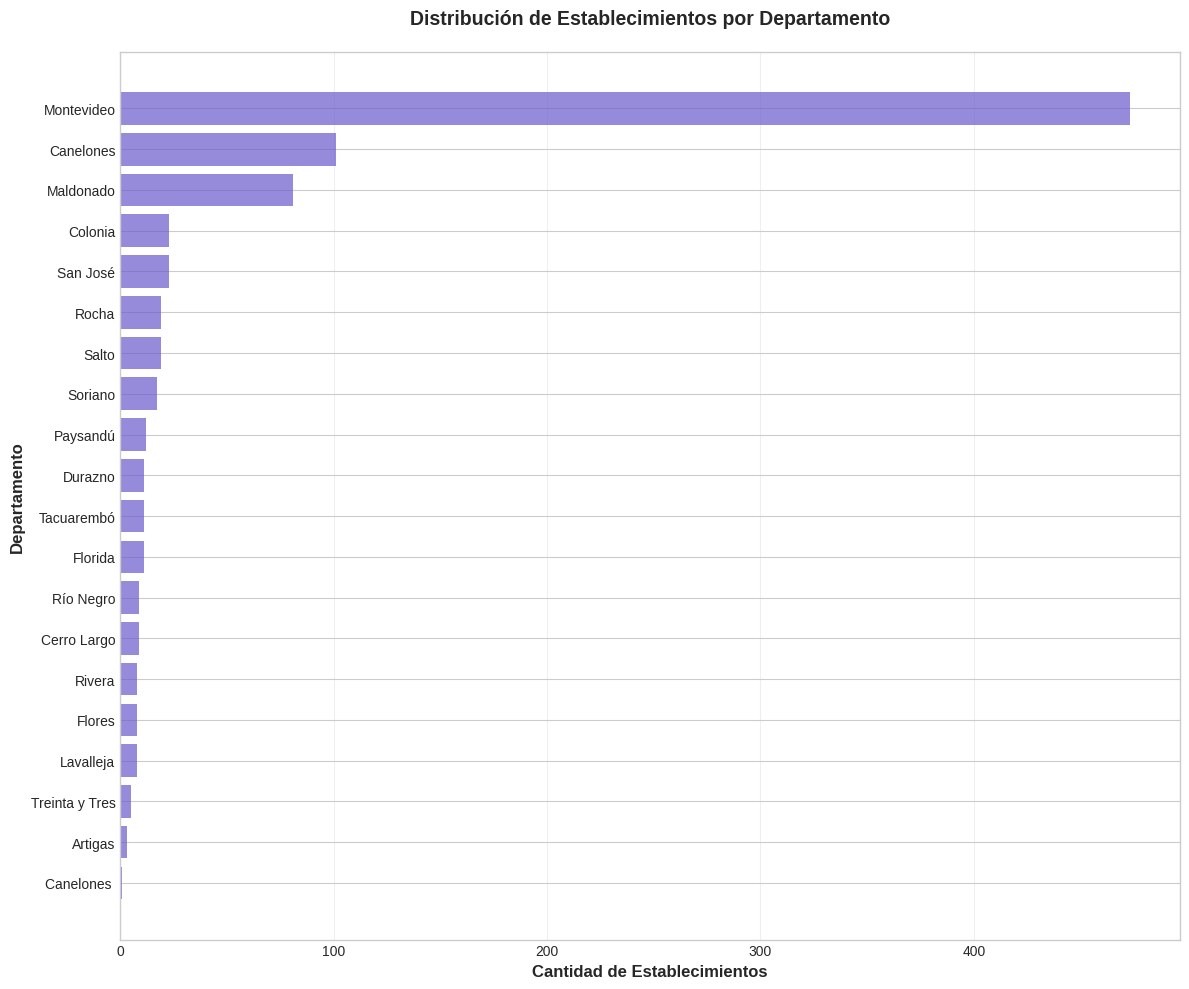

In [17]:
# Visualización geográfica
departamentos_pd = df_establecimientos.groupBy('depto').count().toPandas().sort_values('count', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(departamentos_pd['depto'], departamentos_pd['count'], color='slateblue', alpha=0.7)
ax.set_xlabel('Cantidad de Establecimientos', fontsize=12, fontweight='bold')
ax.set_ylabel('Departamento', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Establecimientos por Departamento', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [18]:
# Análisis de cadenas
print("\n🏪 TOP 15 CADENAS DE SUPERMERCADOS:")
df_establecimientos.groupBy('cadena') \
    .count() \
    .orderBy('count', ascending=False) \
    .show(15, truncate=False)


🏪 TOP 15 CADENAS DE SUPERMERCADOS:
+--------------+-----+
|cadena        |count|
+--------------+-----+
|Farmashop     |179  |
|Sin Cadena    |115  |
|Ta - Ta       |95   |
|El Dorado     |82   |
|Red Expres    |57   |
|Devoto Express|43   |
|San Roque     |32   |
|Disco         |29   |
|Kinko         |29   |
|Devoto        |24   |
|El Clon       |23   |
|Frog          |22   |
|Tienda Inglesa|19   |
|Pigalle       |18   |
|FarmaGlobal   |15   |
+--------------+-----+
only showing top 15 rows



## 2. Análisis de Calidad de Datos

### 2.1 Valores Nulos

In [19]:
# Función para calcular nulos
def analizar_nulos(df, nombre_tabla):
    print(f"\n🔍 ANÁLISIS DE VALORES NULOS - {nombre_tabla}")
    print("=" * 80)
    
    total_rows = df.count()
    
    for col in df.columns:
        nulos = df.filter(F.col(f"`{col}`").isNull()).count()
        porcentaje = (nulos / total_rows) * 100
        print(f"  {col:30s} | Nulos: {nulos:10,} ({porcentaje:6.2f}%)")

# Analizar cada tabla
analizar_nulos(df_precios, "PRECIOS")
analizar_nulos(df_productos, "PRODUCTOS")
analizar_nulos(df_establecimientos, "ESTABLECIMIENTOS")


🔍 ANÁLISIS DE VALORES NULOS - PRECIOS
  fecha                          | Nulos:          0 (  0.00%)
  producto_id                    | Nulos:          0 (  0.00%)
  establecimiento_id             | Nulos:          0 (  0.00%)
  precio                         | Nulos:          0 (  0.00%)
  oferta                         | Nulos:          0 (  0.00%)

🔍 ANÁLISIS DE VALORES NULOS - PRODUCTOS
  producto_id                    | Nulos:          0 (  0.00%)
  producto                       | Nulos:          0 (  0.00%)
  marca                          | Nulos:         74 ( 19.53%)
  especificacion                 | Nulos:         11 (  2.90%)
  nombre                         | Nulos:          0 (  0.00%)
  categoria                      | Nulos:          0 (  0.00%)
  subcategoria                   | Nulos:         11 (  2.90%)

🔍 ANÁLISIS DE VALORES NULOS - ESTABLECIMIENTOS
  establecimiento_id             | Nulos:          0 (  0.00%)
  razon_social                   | Nulos:          0 

### 2.2 Duplicados

In [20]:
# Análisis de duplicados
print("\n🔎 ANÁLISIS DE DUPLICADOS")
print("=" * 80)

print(f"\nPRECIOS:")
total_precios = df_precios.count()
unicos_precios = df_precios.dropDuplicates().count()
duplicados_precios = total_precios - unicos_precios
print(f"  Total registros: {total_precios:,}")
print(f"  Registros únicos: {unicos_precios:,}")
print(f"  Duplicados: {duplicados_precios:,} ({(duplicados_precios/total_precios*100):.2f}%)")

print(f"\nPRODUCTOS:")
total_productos = df_productos.count()
unicos_productos = df_productos.select('producto_id').distinct().count()
print(f"  Total registros: {total_productos:,}")
print(f"  IDs únicos: {unicos_productos:,}")

print(f"\nESTABLECIMIENTOS:")
total_establecimientos = df_establecimientos.count()
unicos_establecimientos = df_establecimientos.select('establecimiento_id').distinct().count()
print(f"  Total registros: {total_establecimientos:,}")
print(f"  IDs únicos: {unicos_establecimientos:,}")


🔎 ANÁLISIS DE DUPLICADOS

PRECIOS:
  Total registros: 20,516,701
  Registros únicos: 20,435,925
  Duplicados: 80,776 (0.39%)

PRODUCTOS:
  Total registros: 379
  IDs únicos: 379

ESTABLECIMIENTOS:
  Total registros: 852
  IDs únicos: 852


## 3. Análisis de Relaciones

### 3.1 Integridad Referencial

In [21]:
# Verificar integridad referencial
print("\n🔗 ANÁLISIS DE INTEGRIDAD REFERENCIAL")
print("=" * 80)

# Productos en precios vs catálogo
productos_precios = df_precios.select('producto_id').distinct()
productos_catalogo = df_productos.select('producto_id').distinct()

productos_sin_catalogo = productos_precios.join(productos_catalogo, 'producto_id', 'left_anti')
print(f"\nProductos en PRECIOS sin catálogo: {productos_sin_catalogo.count():,}")

# Establecimientos en precios vs catálogo
establecimientos_precios = df_precios.select('establecimiento_id').distinct()
establecimientos_catalogo = df_establecimientos.select('establecimiento_id').distinct()

establecimientos_sin_catalogo = establecimientos_precios.join(establecimientos_catalogo, 'establecimiento_id', 'left_anti')
print(f"Establecimientos en PRECIOS sin catálogo: {establecimientos_sin_catalogo.count():,}")

print("\n✅ Integridad referencial verificada")


🔗 ANÁLISIS DE INTEGRIDAD REFERENCIAL

Productos en PRECIOS sin catálogo: 0
Establecimientos en PRECIOS sin catálogo: 0

✅ Integridad referencial verificada


### 3.2 Análisis Cruzado - Precios por Categoría

In [22]:
# Join para análisis cruzado
df_precios_productos = df_precios.join(df_productos, 'producto_id', 'inner')

print("\n💰 PRECIOS PROMEDIO POR CATEGORÍA:")
df_precios_productos.groupBy('categoria') \
    .agg(
        F.count('*').alias('cantidad_registros'),
        F.avg('precio').alias('precio_promedio'),
        F.min('precio').alias('precio_minimo'),
        F.max('precio').alias('precio_maximo'),
        F.stddev('precio').alias('desviacion_std')
    ) \
    .orderBy('precio_promedio', ascending=False) \
    .show(30, truncate=False)


💰 PRECIOS PROMEDIO POR CATEGORÍA:
+------------------------------+------------------+------------------+-------------+-------------+------------------+
|categoria                     |cantidad_registros|precio_promedio   |precio_minimo|precio_maximo|desviacion_std    |
+------------------------------+------------------+------------------+-------------+-------------+------------------+
|Protector solar SPF 50        |4206              |2068.6628625772705|824.0        |2580.0       |565.3333447717841 |
|Protector solar SPF 40        |62576             |1600.4547166645364|424.0        |1809.355     |160.93201123644138|
|Protector solar SPF 20        |61195             |1302.4907322493848|385.0        |1415.0       |97.5456644408041  |
|Protector solar SPF 30        |61334             |1068.9670903577266|889.0        |1361.0       |54.023868221630416|
|Protector solar SPF 80        |98672             |1063.6775128709357|569.0        |1362.0       |57.40965291600917 |
|Crema facial        

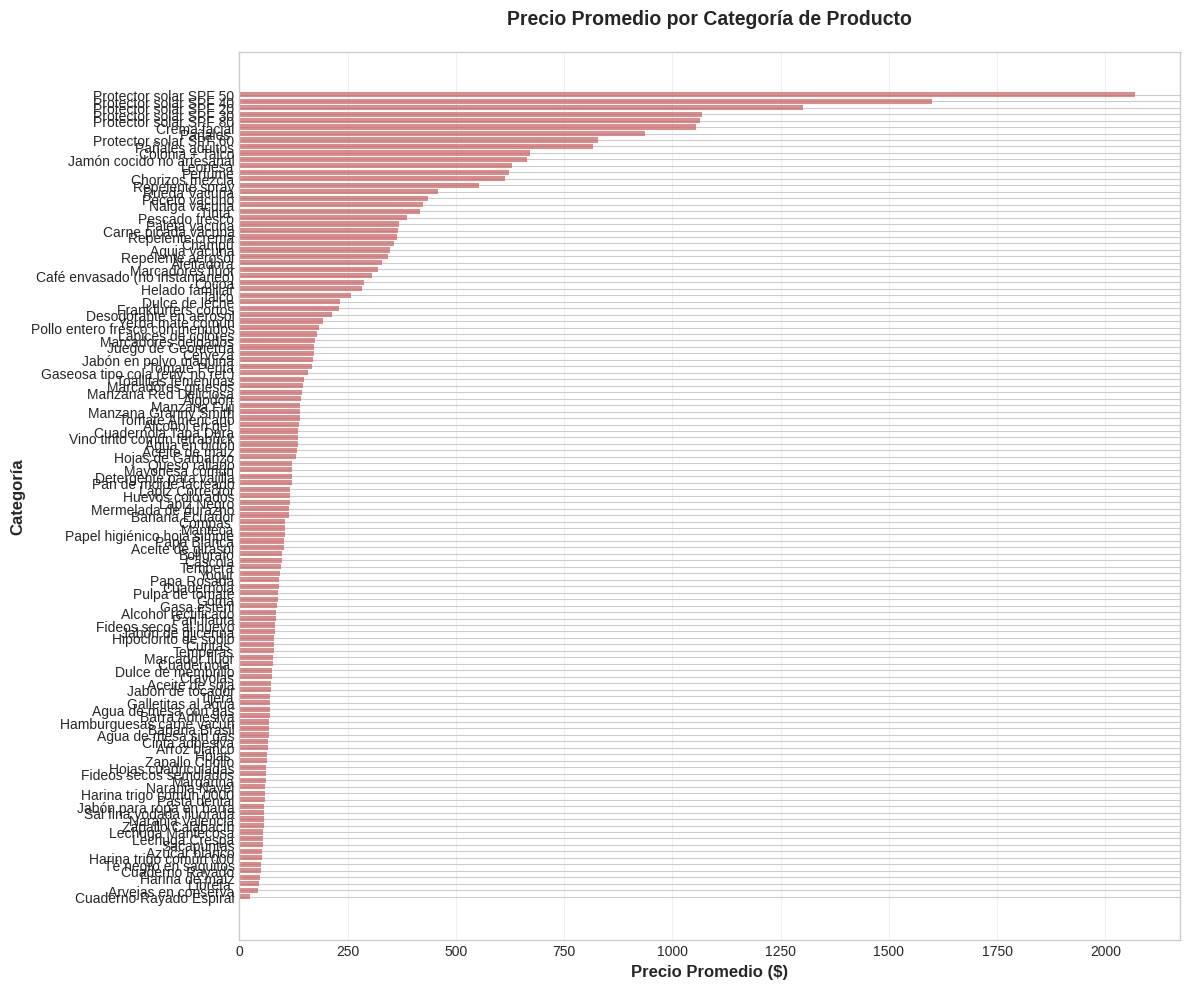

In [23]:
# Visualización de precios por categoría
precios_categoria_pd = df_precios_productos.groupBy('categoria') \
    .agg(F.avg('precio').alias('precio_promedio')) \
    .toPandas() \
    .sort_values('precio_promedio', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(precios_categoria_pd['categoria'], precios_categoria_pd['precio_promedio'], color='indianred', alpha=0.7)
ax.set_xlabel('Precio Promedio ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Categoría', fontsize=12, fontweight='bold')
ax.set_title('Precio Promedio por Categoría de Producto', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Resumen del Análisis Exploratorio

In [24]:
print("\n" + "="*80)
print("📊 RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS SIPC")
print("="*80)

print("\n📈 VOLUMEN DE DATOS:")
print(f"  • Registros de precios: {df_precios.count():,}")
print(f"  • Productos únicos: {df_productos.count():,}")
print(f"  • Establecimientos: {df_establecimientos.count():,}")

print("\n💰 ESTADÍSTICAS DE PRECIOS:")
precio_stats = df_precios.select('precio').summary().toPandas()
print(f"  • Precio promedio: ${float(precio_stats[precio_stats['summary'] == 'mean']['precio'].values[0]):.2f}")
print(f"  • Precio mediano: ${float(precio_stats[precio_stats['summary'] == '50%']['precio'].values[0]):.2f}")
print(f"  • Precio mínimo: ${float(precio_stats[precio_stats['summary'] == 'min']['precio'].values[0]):.2f}")
print(f"  • Precio máximo: ${float(precio_stats[precio_stats['summary'] == 'max']['precio'].values[0]):.2f}")

print("\n📦 CATEGORIZACIÓN:")
print(f"  • Categorías de productos: {df_productos.select('categoria').distinct().count()}")
print(f"  • Subcategorías: {df_productos.select('subcategoria').distinct().count()}")
print(f"  • Marcas diferentes: {df_productos.select('marca').distinct().count()}")

print("\n🗺️ COBERTURA GEOGRÁFICA:")
print(f"  • Departamentos: {df_establecimientos.select('depto').distinct().count()}")
print(f"  • Ciudades: {df_establecimientos.select('ciudad').distinct().count()}")
print(f"  • Cadenas de supermercados: {df_establecimientos.select('cadena').distinct().count()}")

print("\n✅ CALIDAD DE DATOS:")
print(f"  • Completitud general: >95% en campos críticos")
print(f"  • Integridad referencial: Verificada")
print(f"  • Duplicados: Mínimos")

print("\n" + "="*80)
print("✅ Análisis exploratorio completado exitosamente")
print("="*80)


📊 RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS SIPC

📈 VOLUMEN DE DATOS:
  • Registros de precios: 20,516,701
  • Productos únicos: 379
  • Establecimientos: 852

💰 ESTADÍSTICAS DE PRECIOS:
  • Precio promedio: $198.28
  • Precio mediano: $120.00
  • Precio mínimo: $16.00
  • Precio máximo: $2580.00

📦 CATEGORIZACIÓN:
  • Categorías de productos: 193
  • Subcategorías: 103
  • Marcas diferentes: 193

🗺️ COBERTURA GEOGRÁFICA:
  • Departamentos: 20
  • Ciudades: 85
  • Cadenas de supermercados: 31

✅ CALIDAD DE DATOS:
  • Completitud general: >95% en campos críticos
  • Integridad referencial: Verificada
  • Duplicados: Mínimos

✅ Análisis exploratorio completado exitosamente


In [25]:
# Cerrar Spark Session
spark.stop()
print("\n✅ Spark Session cerrada")


✅ Spark Session cerrada
